<a href="https://colab.research.google.com/drive/1HZNsS-LSLKqTTw2fmu3m2CYsxZAFwsIV?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Neural Operators (FNO) in JAX

Neural Operators are mappings between discretized function spaces, for example:

* Map from an initial condition to the solution function at a later point in time (or to the entire spatiotemporal solution funciton)
* Map from the function describing an inhomogeneous diffusivity distribution to the solution of the heat equation
* Autoregressive timesteppers, map state $u^{[t]}_h$ to state $u_h^{[t+1]}$

Fourier Neural Operators do so by employing the FFT to perform efficient **spectral convolution** taking into account global features. In that sense they are a multiscale architecture (Classical convolutional architectures are only local and their receptive field depends on the depth of the network).

Neural Operators allow for the solution of a whole parametric family of PDEs!

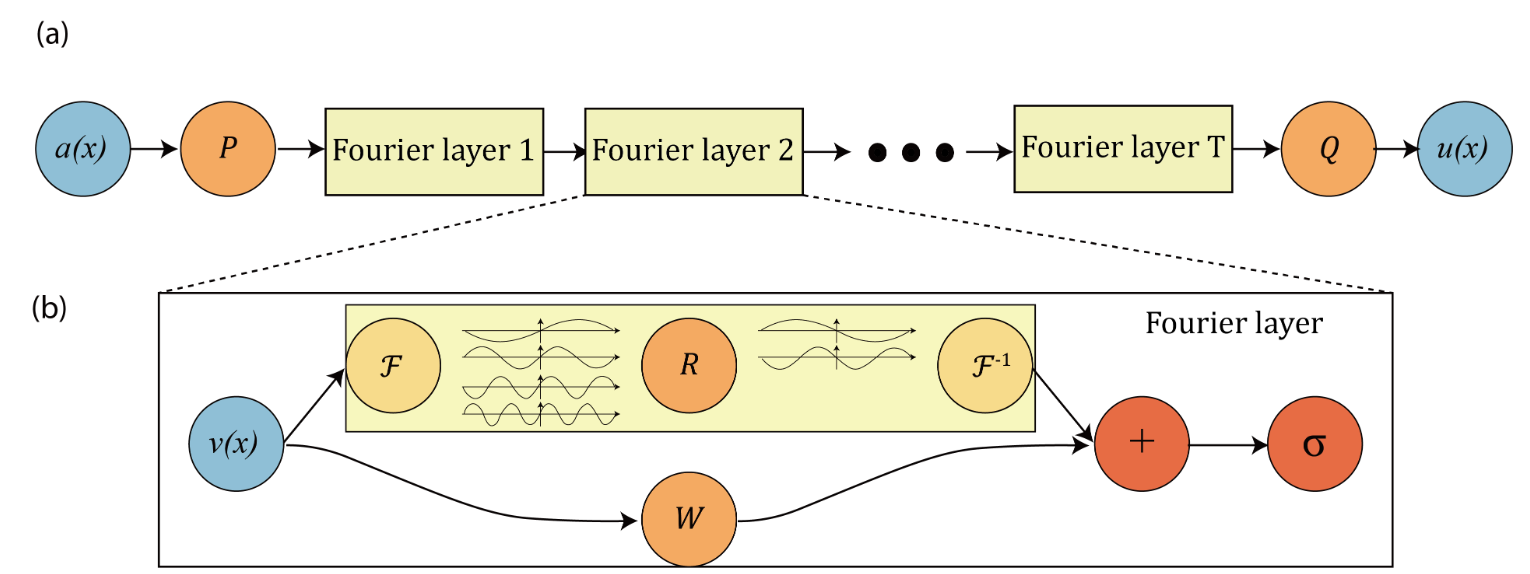

(a) Full architecture of the neural operator: 
* Start from input $a$ (initial, boundary condition, or other functional parameter of the PDE)
* Lift to a higher dimensional channel space by a neural network $P$
* Apply $T$ Fourier layers
* Project back to the target dimension by a neural network $Q$
* Output $u$ (solution of the PDE)

$\textit{Note}$: $P$ and $Q$ consist on 1x1 Convolutions to only modify the channel dimensions. 

(b) Fourier layers
* Start from input $v$
* Apply Spectral Convolution (yellow block), $S = \mathcal{F}^{-1}\circ R\circ \mathcal{F}$
* Apply a local linear transform $W$
* Add $S(v)+W(v)$ and apply activation function

## Spectral Convolutions

Given the (real-valued) input discretized state $a$ (with potentially more than one channel) defined on an equidistant mesh; do the following steps:

1. Transform $a$ into Fourier space (here using the real-valued Fourier transform): $\hat{a} = \text{rfft}(a)$ (batch over the channel dimension)
2. Perform a batched matrix multiplication with a complex-valued weight matrix $R$ for the first $K$ modes: $\hat{\tilde{a}}_{0:K} = R\hat{a}_{0:K}$
3. Set all the leftover modes to zero $\hat{\tilde{a}}_{K:} = 0 + 0i$
4. Transform back into real space $\tilde{a} = \text{irfft}(\hat{\tilde{a}})$

The learnable parameters for each spectral convolution are the complex-valued weight matrix $R$ of shape `(channels_out, channels_in, modes)` (Since it is complex-valued it actually has `2 * channels_out * channels_in * modes` real parameters)

## Example: Burger's equation

Here, we will mimic one example done in the original paper by [Li et al.](https://arxiv.org/pdf/2010.08895.pdf) as implemented in their [reference code](https://github.com/neuraloperator/neuraloperator/blob/af93f781d5e013f8ba5c52baa547f2ada304ffb0/fourier_1d.py) to solve the **1d Burgers equation**

$$ \frac{\partial u}{∂ t} + \frac{1}{2}\frac{\partial u^2}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$

The domain $\Omega = (0, 2 \pi)$ is periodic (i.e., $u(t, x=0) = u(t, x=2 \pi)$) and the viscosity coefficient is fixed to $\nu=0.1$. Our dataset consists of $2048$ initial conditions $u(t=0, x)$ on a $N=8192$ resolution together with their solution at time one $u(t=1, x)$. 

**Goal of FNO:** learn the mapping from initial condition $u(t=0, x)$  to state at time one $u(t=1, x)$ using classical supervised learning. The input to the network is the input state channel-concatenated with the spatial coordinates of the meshpoints. The output is just the state at time one.

### Additional technicalities

* We train on the $32$-fold downsampled dataset (i.e., $256$ DoFs instead of $8192$)
    * Training is on the first 1000 data points
    * Validation/Testing is on the following 200 data points
* The FNO uses $K = 16$ modes, $64$ hidden channels, and has four stacked Fourier layers
* The dataset is reshuffled each epoch and the batch size is $100$
* We perform $200$ epochs in total
* The loss function is the MSE between the network output and true solution
* Training is done with the Adam optimizer in default settings with a fixed learning rate of 3e-4

### Differences from the reference code

There are minor deviations from the [reference implementation](https://github.com/neuraloperator/neuraloperator/blob/af93f781d5e013f8ba5c52baa547f2ada304ffb0/fourier_1d.py), for example:

* Here, the dataset is preconcatenated with the mesh. The mesh is not concatenated with the input on the fly
* No activation in the projection layer $P$. Instead the final Fourier block is activated.

In [1]:
%pip install equinox

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 KB 5.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from typing import Callable, List
import scipy
from tqdm.autonotebook import tqdm

/tmp/ipykernel_2432706/3091149478.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Mathworks (the creators of Matlab) host the original Li et al. dataset in the .mat format
!wget https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat

--2024-03-02 18:23:02--  https://ssd.mathworks.com/supportfiles/nnet/data/burgers1d/burgers_data_R10.mat
Resolving ssd.mathworks.com (ssd.mathworks.com)... 23.207.212.31
Connecting to ssd.mathworks.com (ssd.mathworks.com)|23.207.212.31|:443... connected.
HTTP request sent, awaiting response... 

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


200 OK
Length: 644427710 (615M) [text/plain]
Saving to: ‘burgers_data_R10.mat’

burgers_data_R10.ma 100%[===================>] 614.57M  5.84MB/s    in 1m 45s  

2024-03-02 18:24:47 (5.83 MB/s) - ‘burgers_data_R10.mat’ saved [644427710/644427710]



In [3]:
data = scipy.io.loadmat("burgers_data_R10.mat")

In [15]:
a, u = data["a"], data["u"] 
print(a.shape, u.shape)

(2048, 8192) (2048, 8192)


a represents u(t=0, x) and u represents u(t=1, x)

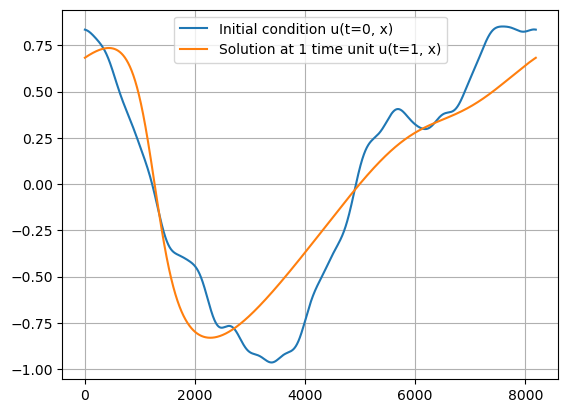

In [16]:
plt.plot(a[0], label="Initial condition u(t=0, x)")
plt.plot(u[0], label="Solution at 1 time unit u(t=1, x)")
plt.legend()
plt.grid()

In [17]:
# Add channel dimension
a = a[:, jnp.newaxis, :]
u = u[:, jnp.newaxis, :]
print(a.shape, u.shape)

(2048, 1, 8192) (2048, 1, 8192)


In [18]:
# Create mesh
# Mesh is from 0 to 2 pi
mesh = jnp.linspace(0, 2 * jnp.pi, u.shape[-1])

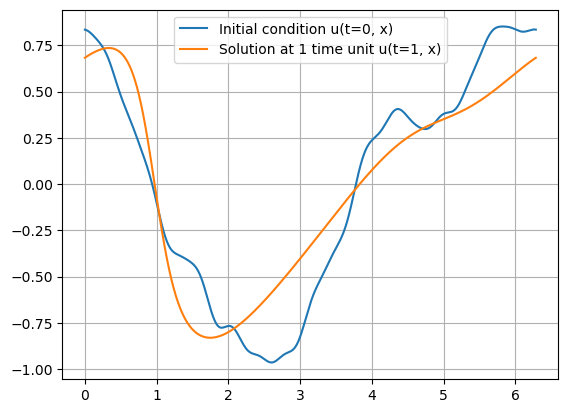

In [19]:
plt.plot(mesh, a[0, 0], label="Initial condition u(t=0, x)")
plt.plot(mesh, u[0, 0], label="Solution at 1 time unit u(t=1, x)")
plt.legend()
plt.grid()

In [21]:
# Concatenate mesh to initial conditions (inputs of the FNO)
mesh_shape_corrected = jnp.repeat(mesh[jnp.newaxis, jnp.newaxis, :], u.shape[0], axis=0)
a_with_mesh = jnp.concatenate((a, mesh_shape_corrected), axis=1)
print(a_with_mesh.shape)

(2048, 2, 8192)


In [22]:
# Train-test split
train_x, test_x = a_with_mesh[:1000], a_with_mesh[1000:1200]
train_y, test_y = u[:1000], u[1000:1200]

### Model components
#### 1. Spectral Convolution

In [23]:
class SpectralConv1d(eqx.Module):
    real_weights: jax.Array
    imag_weights: jax.Array
    in_channels: int
    out_channels: int
    modes: int

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            *,
            key,
    ):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        scale = 1.0 / (in_channels * out_channels)

        real_key, imag_key = jax.random.split(key)
        self.real_weights = jax.random.uniform(
            real_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )
        self.imag_weights = jax.random.uniform(
            imag_key,
            (in_channels, out_channels, modes),
            minval=-scale,
            maxval=+scale,
        )

    def complex_mult1d(
            self,
            x_hat,
            w,
    ):
        return jnp.einsum("iM,ioM->oM", x_hat, w)


    def __call__(
            self,
            x,
    ):
        channels, spatial_points = x.shape

        # shape of x_hat is (in_channels, spatial_points//2+1)
        x_hat = jnp.fft.rfft(x)
        # shape of x_hat_under_modes is (in_channels, self.modes)
        x_hat_under_modes = x_hat[:, :self.modes]
        weights = self.real_weights + 1j * self.imag_weights
        # shape of out_hat_under_modes is (out_channels, self.modes)
        out_hat_under_modes = self.complex_mult1d(x_hat_under_modes, weights)

        # shape of out_hat is (out_channels, spatial_points//2+1)
        out_hat = jnp.zeros(
            (self.out_channels, x_hat.shape[-1]),
            dtype=x_hat.dtype
        )
        out_hat = out_hat.at[:, :self.modes].set(out_hat_under_modes)

        out = jnp.fft.irfft(out_hat, n=spatial_points)

        return out


#### 2. Fourier Layer

In [24]:
class FNOBlock1d(eqx.Module):
    spectral_conv: SpectralConv1d
    bypass_conv: eqx.nn.Conv1d
    activation: Callable

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            activation,
            *,
            key,
    ):
        spectral_conv_key, bypass_conv_key = jax.random.split(key)
        self.spectral_conv = SpectralConv1d(
            in_channels,
            out_channels,
            modes,
            key=spectral_conv_key,
        )
        self.bypass_conv = eqx.nn.Conv1d(
            in_channels,
            out_channels,
            1,  # Kernel size is one
            key=bypass_conv_key,
        )
        self.activation = activation

    def __call__(
            self,
            x,
    ):
        return self.activation(
            self.spectral_conv(x) + self.bypass_conv(x)
        )

#### 3. Overall model

In [25]:
class FNO1d(eqx.Module):
    lifting: eqx.nn.Conv1d
    fno_blocks: List[FNOBlock1d]
    projection: eqx.nn.Conv1d

    def __init__(
            self,
            in_channels,
            out_channels,
            modes,
            width,
            activation,
            n_blocks = 4,
            *,
            key,
    ):
        key, lifting_key = jax.random.split(key)
        self.lifting = eqx.nn.Conv1d(
            in_channels,
            width,
            1,
            key=lifting_key,
        )

        self.fno_blocks = []
        for i in range(n_blocks):
            key, subkey = jax.random.split(key)
            self.fno_blocks.append(FNOBlock1d(
                width,
                width,
                modes,
                activation,
                key=subkey,
            ))

        key, projection_key = jax.random.split(key)
        self.projection = eqx.nn.Conv1d(
            width,
            out_channels,
            1,
            key=projection_key,
        )

    def __call__(
            self,
            x,
    ):
        x = self.lifting(x)

        for fno_block in self.fno_blocks:
            x = fno_block(x)

        x = self.projection(x)

        return x

### FNO in action

##### Define FNO operator with adequate parameters

In [26]:
fno = FNO1d(
    2, # 2 input channels (u(0) and mesh)
    1, # 1 output channel (u(1))
    16, # maximum number of modes
    64, # hidden channels dimension
    jax.nn.relu,  # activation function
    key=jax.random.PRNGKey(0),
)

##### Load data

In [27]:
def dataloader(
    key,
    dataset_x,
    dataset_y,
    batch_size,
):
    n_samples = dataset_x.shape[0]

    n_batches = int(jnp.ceil(n_samples / batch_size))

    permutation = jax.random.permutation(key, n_samples)

    for batch_id in range(n_batches):
        start = batch_id * batch_size
        end = min((batch_id + 1) * batch_size, n_samples)

        batch_indices = permutation[start:end]

        yield dataset_x[batch_indices], dataset_y[batch_indices]

##### Training loop

In [28]:
# Loss function
def loss_fn(model, x, y):
    y_pred = jax.vmap(model)(x)
    loss = jnp.mean(jnp.square(y_pred - y))
    return loss



# Optimizer
optimizer = optax.adam(3e-4)
opt_state = optimizer.init(eqx.filter(fno, eqx.is_array))



# Training step
@eqx.filter_jit
def make_step(model, state, x, y):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(model, x, y)
    val_loss = loss_fn(model, test_x[..., ::32], test_y[..., ::32])
    updates, new_state = optimizer.update(grad, state, model)
    new_model = eqx.apply_updates(model, updates)
    return new_model, new_state, loss, val_loss


# Training loop
loss_history = []
val_loss_history = []

shuffle_key = jax.random.PRNGKey(10)
for epoch in tqdm(range(200)):
    shuffle_key, subkey = jax.random.split(shuffle_key)
    for (batch_x, batch_y) in dataloader(
        subkey,
        train_x[..., ::32],
        train_y[..., ::32],
        batch_size=100,
    ):
        fno, opt_state, loss, val_loss = make_step(fno, opt_state, batch_x, batch_y)
        loss_history.append(loss)
        val_loss_history.append(val_loss)

100%|██████████| 200/200 [10:17<00:00,  3.09s/it]


##### Plot training and validation losses

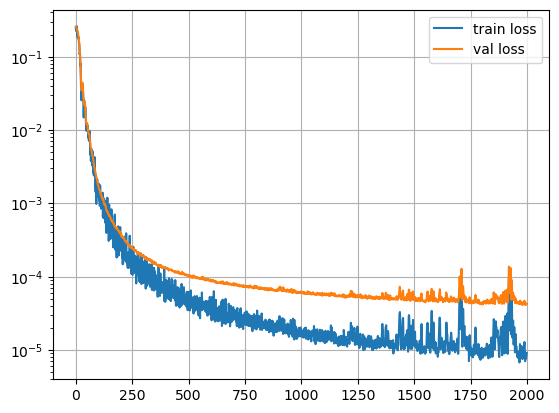

In [29]:
plt.plot(loss_history, label="train loss")
plt.plot(val_loss_history, label="val loss")
plt.legend()
plt.yscale("log")
plt.grid()

##### Plot FNO output vs ground truth

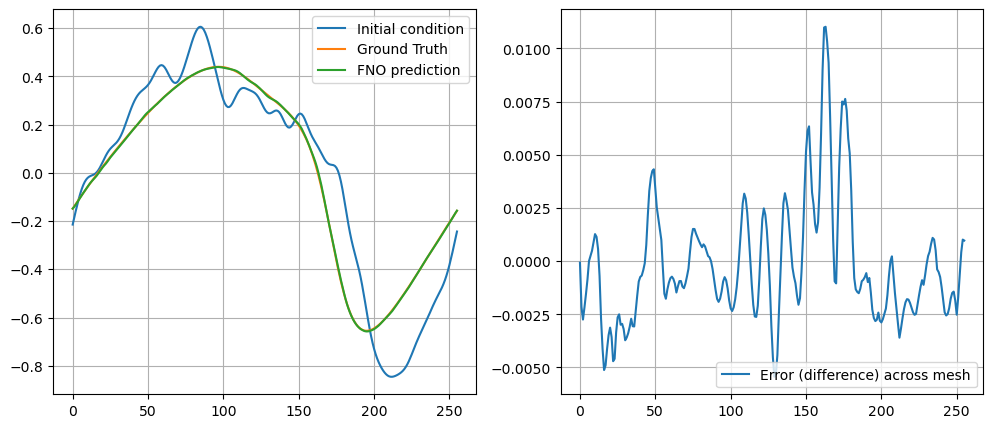

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Creating subplots with 1 row and 2 columns

# Plotting the first subplot
axs[0].plot(test_x[1, 0, ::32], label="Initial condition")
axs[0].plot(test_y[1, 0, ::32], label="Ground Truth")
axs[0].plot(fno(test_x[1, :, ::32])[0], label="FNO prediction")
axs[0].legend()
axs[0].grid()

# Plotting the second subplot
axs[1].plot(fno(test_x[1, :, ::32])[0] - test_y[1, 0, ::32], label="Error (difference) across mesh")
axs[1].legend()
axs[1].grid()

plt.show()

##### Zero-shot superresolution
Instead of evaluating the performance of the FNO on the $32$-fold downsampled dataset used for training, we use a $4$-fold downsampled dataset.

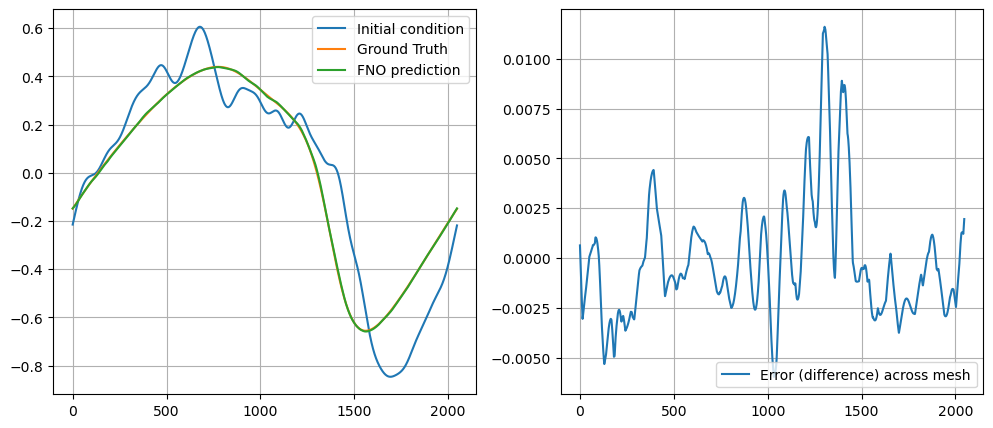

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Creating subplots with 1 row and 2 columns

# Plotting the first subplot
axs[0].plot(test_x[1, 0, ::4], label="Initial condition")
axs[0].plot(test_y[1, 0, ::4], label="Ground Truth")
axs[0].plot(fno(test_x[1, :, ::4])[0], label="FNO prediction")
axs[0].legend()
axs[0].grid()

# Plotting the second subplot
axs[1].plot(fno(test_x[1, :, ::4])[0] - test_y[1, 0, ::4], label="Error (difference) across mesh")
axs[1].legend()
axs[1].grid()

plt.show()

##### Compute error metrics using the relative l2 norm

In [ ]:
# Compute the error as reported in the FNO paper
test_pred = jax.vmap(fno)(test_x)

def relative_l2_norm(pred, ref):
    diff_norm = jnp.linalg.norm(pred - ref)
    ref_norm = jnp.linalg.norm(ref)
    return diff_norm / ref_norm

rel_l2_set = jax.vmap(relative_l2_norm)(test_pred, test_y)

In [ ]:
rel_l2_set.shape # Check that the shape coincides with the number of samples in the test set

(200,)

In [ ]:
jnp.mean(rel_l2_set) # ~1e-2

Array(0.00950637, dtype=float32)